In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib widget

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

-80.932416


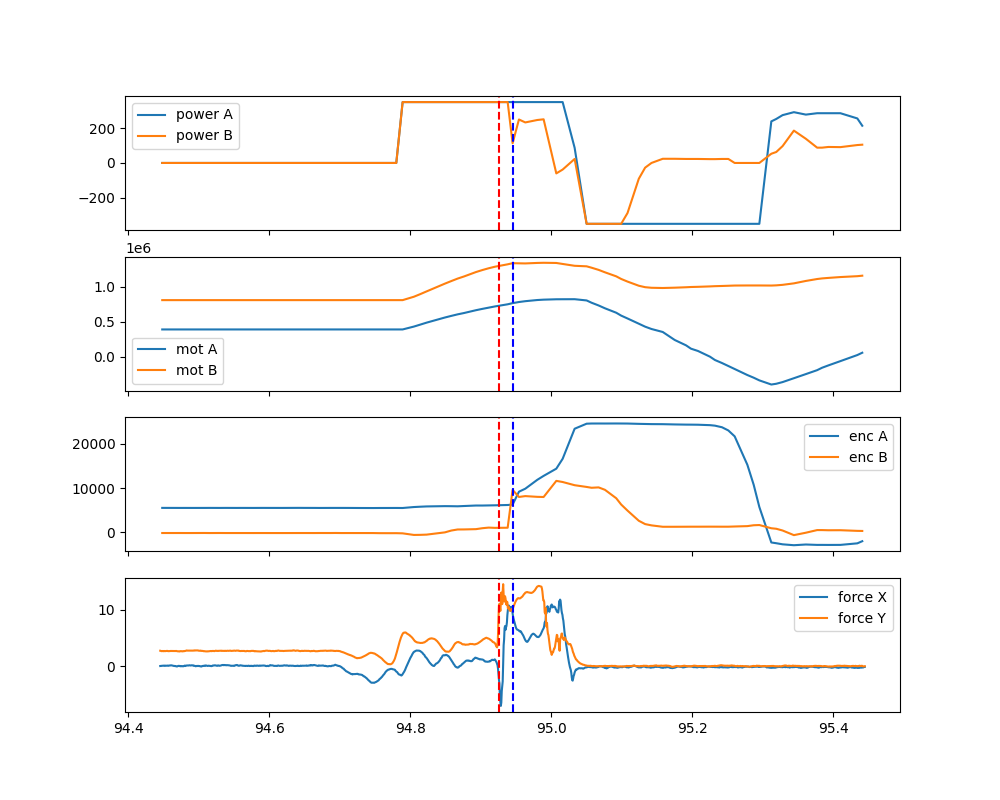

In [36]:
brain_data_path = "./brain_data/2024-07-27_22-34-11_encoder.txt"
force_data_unfilt_path = "./force_data/2024-07-27_22-35-21_force.txt" #every other line is empty

df_log = extract_from_txt(
    brain_data_path, 
    [
        't',
        'pA',
        'pB',
        'mA',
        'mB',
        'eA', 
        'eB', 
        'I'
    ],
    '#'
)

force_data_path = force_data_unfilt_path[:-4] + '_filt.txt'
remove_even_lines(force_data_unfilt_path, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)


df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
df_log['side_mot_pow'] = -df_log['pA']
df_log['center_mot_pow'] = -df_log['pB']


df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force['Fx'] = -df_force['N23']
df_force['Fy'] = df_force['N67']

manual_offset = 0.02
time_before = 0.5
time_after = 0.5


force_thres_t = df_force[df_force['Fy'] > 8]['time'].iloc[0]
enc_thres_t = df_log[df_log['center_enc_pos'] > 6.5e3]['time'].iloc[0]
offset = force_thres_t - enc_thres_t + manual_offset

print(offset)

df_force.loc[:,'time'] = df_force.loc[:,'time'] - offset


df_log = df_log[df_log['time'] > enc_thres_t - time_before]
df_log = df_log[df_log['time'] < enc_thres_t + time_after]
df_log = df_log.reset_index()

df_force = df_force[df_force['time'] > enc_thres_t - time_before]
df_force = df_force[df_force['time'] < enc_thres_t + time_after]
df_force = df_force.reset_index()



fig, axs = plt.subplots(4,1,figsize=(10,8), sharex=True)
axs[0].plot(df_log['time'], df_log['side_mot_pow'], label='power A')
axs[0].plot(df_log['time'], df_log['center_mot_pow'], label='power B')
axs[1].plot(df_log['time'], df_log['side_mot_pos'], label='mot A')
axs[1].plot(df_log['time'], df_log['center_mot_pos'], label='mot B')
axs[2].plot(df_log['time'], df_log['side_enc_pos'], label='enc A')
axs[2].plot(df_log['time'], df_log['center_enc_pos'], label='enc B')
axs[3].plot(df_force['time'], df_force['Fx'], label='force X')
axs[3].plot(df_force['time'], df_force['Fy'], label='force Y')
for ax in axs:
    ax.legend()


for ax in axs:
    ax.axvline(x=force_thres_t - offset, color='r', linestyle='--')
    ax.axvline(x=enc_thres_t, color='b', linestyle='--')
